# Time Series Prediction and Forecast

 **Overview**
> This is the final stage of the project (modelling stage). In this stage we generate time series forecasting models to check the rates of three variables related to anxiolytics:
> - Items Per Person (Population weighted)
> - Cost Per Person (Population weighted)
> - Quantity Per Person (Population weighted)

> I used Time series decomposition and STL to understand the time series data. Auto arima and SARIMAX model are used to predict and forecast the time series data.

>  Spearman coefficient of correaltion values have been used as an exogenous variable in SARIMAX.

> The Metrics used for selection and evaluation are:
> - AIC
> - MAPE
> - MAE
> - RMSE
> - corr

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure
from pandas.tseries.offsets import DateOffset
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import STL

In [2]:
lad_anxiolytics_iod = pd.read_csv("lad_anxiolytics_iod.csv")
lad_anxiolytics_iod['Date'] =  pd.to_datetime(lad_anxiolytics_iod['Date'],yearfirst=True)

--- 
## ITEMS

In [3]:
lad_anxiolytics_iod_item = lad_anxiolytics_iod[["Date","Items Per Person"]]
lad_anxiolytics_iod_item = lad_anxiolytics_iod_item.groupby(['Date']).sum()[['Items Per Person']]
items = lad_anxiolytics_iod_item

In [4]:
# train test split
train_item = items["Items Per Person"][:42]
test_item = items["Items Per Person"][42:]

In [5]:
pred_start = test_item.index[0]
pred_end = test_item.index[-1]

<AxesSubplot:xlabel='Date'>

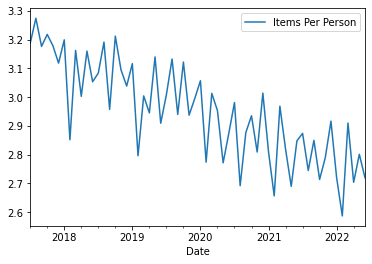

In [6]:
items.plot()

<Figure size 720x504 with 0 Axes>

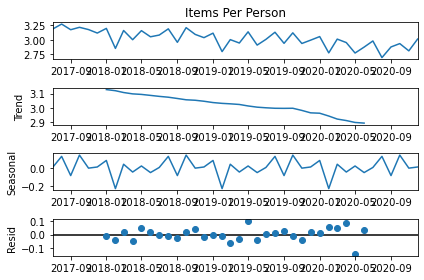

In [7]:
plt.figure(figsize=(10,7))
result = seasonal_decompose(train_item, model='additive')
res = result.plot()

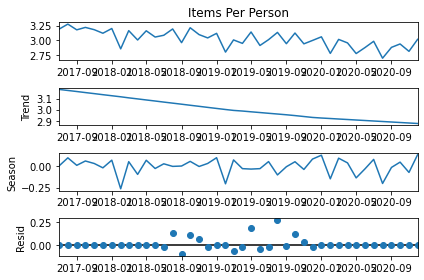

In [8]:
res = STL(train_item, robust = True).fit() 
res.plot()
plt.show()

The seasonal component is additive as it is not getting multiplied over the period of time 

The data has a seasonality component to it with a downward trend

In [9]:
def adfuller_test(prescriptions):
    result = adfuller(prescriptions)
    labels = ["ADF Test Statistic",'p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+':'+str(value))
    if result[1] <= 0.05:
        print("Reject the Null Hypothesis and data is stationary ")
    else:
        print("Failed to reject the Null Hypothesis and data is not stationary")

In [10]:
adfuller_test(train_item)

ADF Test Statistic:-1.7422652987780953
p-value:0.40947812211640044
#Lags Used:2
Number of Observations Used:39
Failed to reject the Null Hypothesis and data is not stationary


In [11]:
adfuller_test(train_item.diff().dropna())

ADF Test Statistic:-4.374294374205301
p-value:0.0003295182631199799
#Lags Used:10
Number of Observations Used:30
Reject the Null Hypothesis and data is stationary 


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-65.903, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23.916, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-51.394, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-25.891, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-66.176, Time=0.32 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-49.409, Time=0.16 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-63.711, Time=0.32 sec

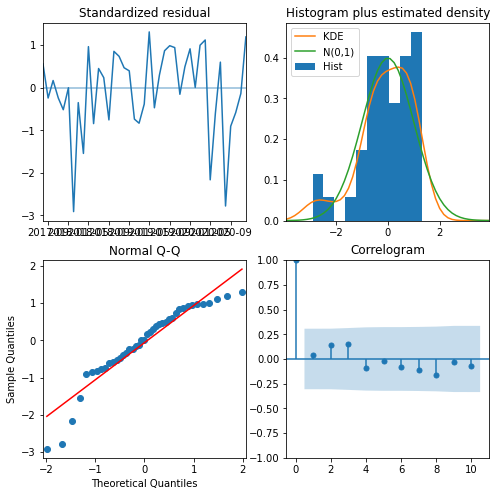

In [12]:
# Auto Arima to make the data stationary and get the p,d,q values with the lowest AIC scores

step_wise = pm.auto_arima(train_item, start_p=1, start_q=1,
                         max_p=7, max_q=7,m=12,seasonal_test_args={"max_lag": 1}, seasonal=True,
                         d=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,random_state=42)

print(step_wise.summary())
step_wise.plot_diagnostics(figsize=(8,8))
plt.show()

In [13]:
model= SARIMAX(train_item, order=(2,1,0),seasonal_order=(1,0,0,12),enforce_invertibility=False,
               enforce_stationarity=False)

model_fit = model.fit()
print(model_fit.summary())

items["Forecast"] = model_fit.predict(start=pred_start,end=pred_end)

                                     SARIMAX Results                                      
Dep. Variable:                   Items Per Person   No. Observations:                   42
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  27.870
Date:                            Fri, 09 Sep 2022   AIC                            -47.740
Time:                                    19:31:46   BIC                            -42.557
Sample:                                07-01-2017   HQIC                           -46.199
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9523      0.211     -4.521      0.000      -1.365      -0.539
ar.L2         -0.7055      0.124   

<AxesSubplot:ylabel='Density'>

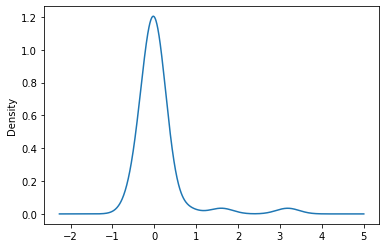

In [14]:
model_fit.resid.plot(kind='kde')

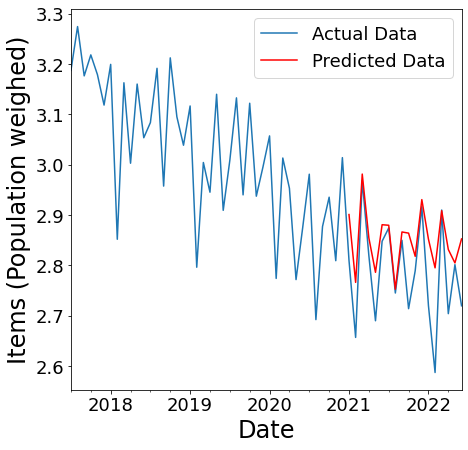

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
ax = items["Items Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Items (Population weighed)'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Items (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
items["Forecast"].plot(ax=ax, style='r', label='Predicted Data')
legend = ax.legend(loc='upper right', prop={'size': 18})
plt.show()
fig.savefig('Items uni.jpg')

In [16]:
def model_evaluation_metrics(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE

    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'Mean Absolute Percentage Error':mape,'Mean Absolute Error': mae,'Root Mean Square Error':rmse, 
            'Correlation Between Actual and Predicted/Forecasted Values':corr, 'Min-Max Error':minmax})


model_evaluation_metrics(items['Items Per Person'][42:], items["Forecast"][42:])

{'Mean Absolute Percentage Error': 0.02361370432020583,
 'Mean Absolute Error': 0.06691125513976116,
 'Root Mean Square Error': 0.09139980667927487,
 'Correlation Between Actual and Predicted/Forecasted Values': 0.7956084866131603,
 'Min-Max Error': 0.023613691556956473}

---

## Forecasting Items

In [17]:
from pandas.tseries.offsets import DateOffset
future_dates = [items.index[-1]+ DateOffset(months=x) for x in range(0,31)]

In [18]:
future_dates_items = pd.DataFrame(index = future_dates[1:],columns=items.columns)

In [19]:
future_forecast_items = pd.concat([items,future_dates_items])
del future_forecast_items["Forecast"]

In [20]:
pred_start_future_items = future_forecast_items.index[59]
pred_end_future_items = future_forecast_items.index[-1]

In [21]:
pred_start_future_items
pred_end_future_items

Timestamp('2024-12-01 00:00:00')

In [22]:
model= SARIMAX(future_forecast_items, 
 order=(2,1,0),seasonal_order=(1,0,0,12),
 enforce_invertibility=False, enforce_stationarity=False)

future_model = model.fit()
print(future_model.summary())

future_forecast_items["Forecast"] = future_model.predict(start=pred_start_future_items,end=pred_end_future_items,
                                                         dynamic=True)

                                     SARIMAX Results                                      
Dep. Variable:                   Items Per Person   No. Observations:                   90
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                  48.747
Date:                            Fri, 09 Sep 2022   AIC                            -89.493
Time:                                    19:31:46   BIC                            -80.223
Sample:                                07-01-2017   HQIC                           -85.792
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9390      0.144     -6.524      0.000      -1.221      -0.657
ar.L2         -0.6896      0.101   

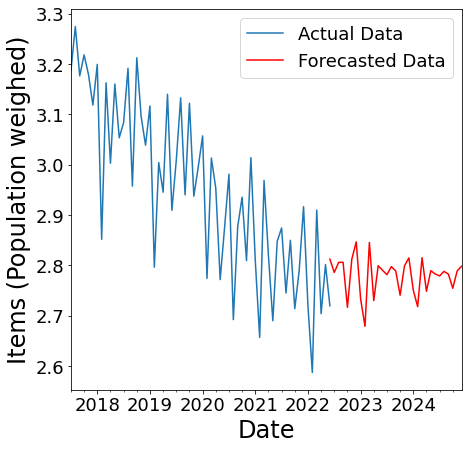

In [23]:
fig, ax = plt.subplots(figsize=(7,7))
ax = future_forecast_items["Items Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Items per Person'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Items (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
future_forecast_items["Forecast"].plot(ax=ax, style='r', label='Forecasted Data')
legend = ax.legend(loc='upper right',prop={'size': 18})
plt.show()
fig.savefig('Items forecast.jpg')

---
# Cost

In [24]:
lad_anxiolytics_iod = pd.read_csv("lad_anxiolytics_iod.csv")
lad_anxiolytics_iod['Date'] =  pd.to_datetime(lad_anxiolytics_iod['Date'],yearfirst=True)

In [25]:
lad_anxiolytics_iod_cost = lad_anxiolytics_iod[["Date","Cost Per Person"]]
lad_anxiolytics_iod_cost = lad_anxiolytics_iod_cost.groupby(['Date']).sum()[['Cost Per Person']]
cost = lad_anxiolytics_iod_cost


In [26]:
cost.head()

,Cost Per Person
Date,
2017-07-01,10.193646
2017-08-01,9.902425
2017-09-01,9.457754
2017-10-01,9.115325
2017-11-01,9.028775


In [27]:
# train test split
train_cost = cost["Cost Per Person"][:30]
test_cost = cost["Cost Per Person"][30:]

In [28]:
pred_start = test_cost.index[0]
pred_end = test_cost.index[-1]

<AxesSubplot:xlabel='Date'>

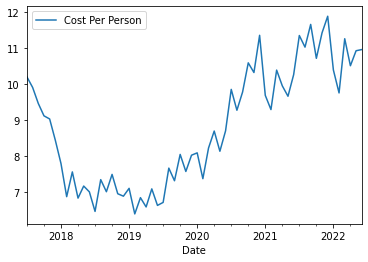

In [29]:
cost.plot()

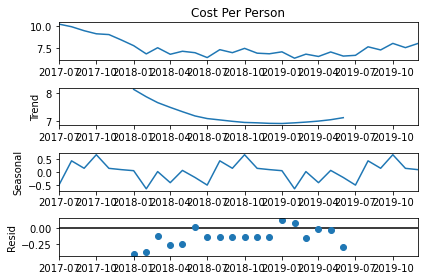

In [30]:
# Time Series Decomposition
result = seasonal_decompose(train_cost, model='additive')
result.plot()
plt.show()

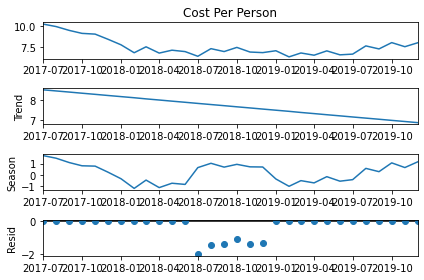

In [31]:
res = STL(train_cost, robust = True).fit() 
res.plot()
plt.show()

In [32]:
adfuller_test(train_cost)

ADF Test Statistic:-2.004230861742996
p-value:0.28472110053587113
#Lags Used:6
Number of Observations Used:23
Failed to reject the Null Hypothesis and data is not stationary


In [33]:
adfuller_test(train_cost.diff().dropna())

ADF Test Statistic:-1.631826227509519
p-value:0.4665349379273897
#Lags Used:7
Number of Observations Used:21
Failed to reject the Null Hypothesis and data is not stationary


In [34]:
adfuller_test(train_cost.diff().diff().dropna())

ADF Test Statistic:-2.2853615995228296
p-value:0.17673261884208413
#Lags Used:9
Number of Observations Used:18
Failed to reject the Null Hypothesis and data is not stationary


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=75.202, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=47.781, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=50.272, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=47.095, Time=0.16 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=60.039, Time=0.14 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=41.717, Time=0.17 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(2,

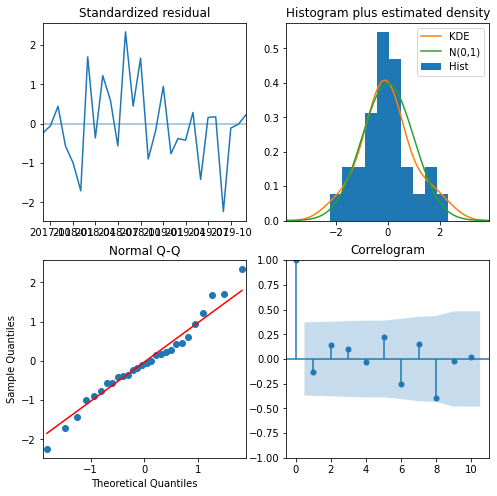

In [35]:
# Auto Arima to make the data stationary and get the p,d,q values with the lowest AIC scores

step_wise = pm.auto_arima(train_cost, start_p=1, start_q=1,
                         max_p=7, max_q=7,m=12,seasonal_test_args={"max_lag": 1}, seasonal=True,
                         d=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,random_state=42)
print(step_wise.summary())
step_wise.plot_diagnostics(figsize=(8,8))
plt.show()

In [36]:
model= SARIMAX(train_cost, order=(0,1,0),seasonal_order=(2,0,1,12),enforce_invertibility=False,
               enforce_stationarity=False)
               
model_fit = model.fit()
print(model_fit.summary())

cost["Forecast"] = model_fit.predict(start=pred_start,end=pred_end,dynamic=True)

                                      SARIMAX Results                                       
Dep. Variable:                      Cost Per Person   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood                   2.295
Date:                              Fri, 09 Sep 2022   AIC                              3.411
Time:                                      19:31:55   BIC                              1.848
Sample:                                  07-01-2017   HQIC                            -0.782
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       1.0116      0.241      4.206      0.000       0.540       1.483
ar.S.L24      -0.54

<AxesSubplot:ylabel='Density'>

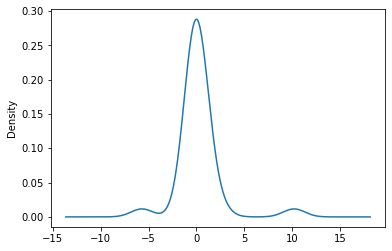

In [37]:
model_fit.resid.plot(kind='kde')

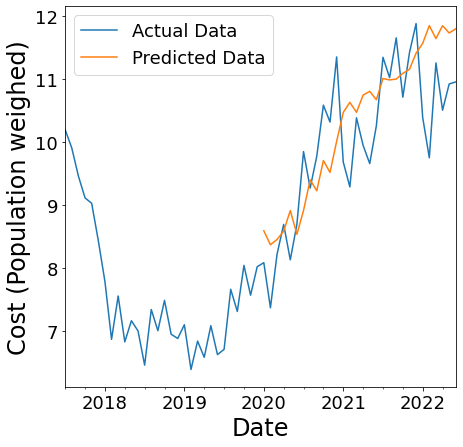

In [38]:
fig, ax = plt.subplots(figsize=(7,7))
ax = cost["Cost Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Cost per Person (Pound Sterling)'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Cost (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cost["Forecast"].plot(ax=ax, style='-', label='Predicted Data')
legend = ax.legend(loc='upper left',prop={'size': 18})
plt.show()
prop={'size': 18}
fig.savefig('Cost uni.jpg')

In [39]:
model_evaluation_metrics(cost["Cost Per Person"][30:], cost["Forecast"][30:])

{'Mean Absolute Percentage Error': 0.06645527737266438,
 'Mean Absolute Error': 0.6912294066400932,
 'Root Mean Square Error': 0.8342811952831013,
 'Correlation Between Actual and Predicted/Forecasted Values': 0.7629478604135989,
 'Min-Max Error': 0.06479527981501076}

---
## Forecasting Cost

In [40]:
future_dates = [cost.index[-1]+ DateOffset(months=x) for x in range(0,31)]

In [41]:
future_dates_cost = pd.DataFrame(index = future_dates[1:],columns=cost.columns)

In [42]:
future_forecast_cost = pd.concat([cost,future_dates_cost])
del future_forecast_cost["Forecast"]

In [43]:
pred_start_future_cost = future_forecast_cost.index[59]
pred_end_future_cost = future_forecast_cost.index[-1]

In [44]:
model= SARIMAX(future_forecast_cost, 
 order=(0,1,0),seasonal_order=(2,0,1,12),
 enforce_invertibility=False, enforce_stationarity=False)

future_model = model.fit()
print(future_model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                      Cost Per Person   No. Observations:                   90
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood                 -32.928
Date:                              Fri, 09 Sep 2022   AIC                             73.856
Time:                                      19:31:56   BIC                             82.554
Sample:                                  07-01-2017   HQIC                            77.288
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.6632      0.462      1.437      0.151      -0.241       1.568
ar.S.L24      -0.43

In [45]:
future_forecast_cost["Forecast"] = future_model.predict(start=pred_start_future_cost,end=pred_end_future_cost,
                                                         dynamic=True)


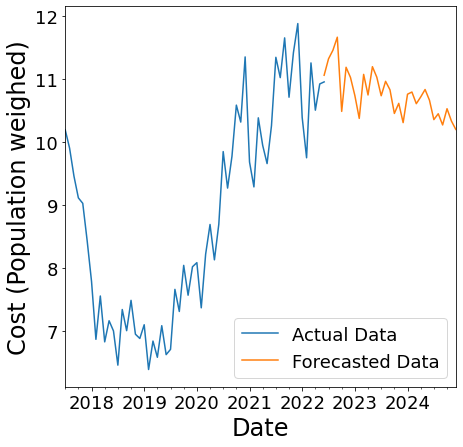

In [46]:
fig, ax = plt.subplots(figsize=(7,7))
ax = future_forecast_cost["Cost Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Cost per Person (Pound Sterling)'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Cost (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
future_forecast_cost["Forecast"].plot(ax=ax, style='-', label='Forecasted Data')
legend = ax.legend(loc='lower right',prop={'size': 18})
plt.show()
fig.savefig('Cost forecast.jpg')

---
# Quantity

In [47]:
lad_anxiolytics_iod = pd.read_csv("lad_anxiolytics_iod.csv")
lad_anxiolytics_iod['Date'] =  pd.to_datetime(lad_anxiolytics_iod['Date'],yearfirst=True)

In [48]:
lad_anxiolytics_iod_quantity = lad_anxiolytics_iod[["Date","Quantity Per Person"]]
lad_anxiolytics_iod_quantity = lad_anxiolytics_iod_quantity.groupby(['Date']).sum()[['Quantity Per Person']]
quantity = lad_anxiolytics_iod_quantity


In [49]:
quantity.head()


,Quantity Per Person
Date,
2017-07-01,100.027399
2017-08-01,103.107215
2017-09-01,99.744781
2017-10-01,101.446354
2017-11-01,100.606037


In [50]:
train_quantity = quantity["Quantity Per Person"][:42]
test_quantity = quantity["Quantity Per Person"][42:]

In [51]:
pred_start = test_quantity.index[0]
pred_end = test_quantity.index[-1]

<AxesSubplot:xlabel='Date'>

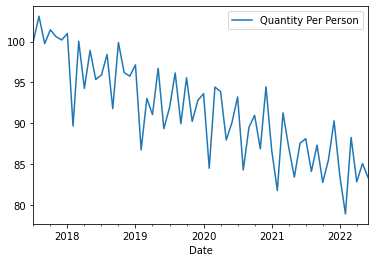

In [52]:
quantity.plot()

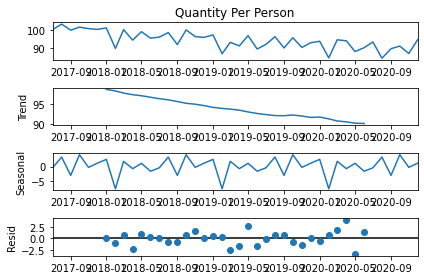

In [53]:
result = seasonal_decompose(train_quantity, model='additive')
result.plot()
plt.show()

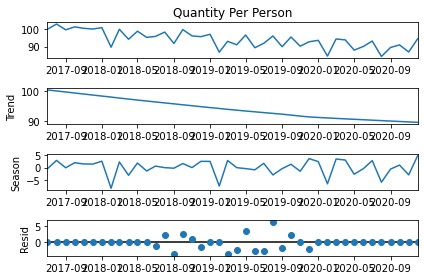

In [54]:
res = STL(train_quantity, robust = True).fit() 
res.plot()
plt.show()

In [55]:
adfuller_test(train_quantity)


ADF Test Statistic:-1.7944637057581074
p-value:0.38321375361700205
#Lags Used:2
Number of Observations Used:39
Failed to reject the Null Hypothesis and data is not stationary


In [56]:
adfuller_test(train_quantity.diff().dropna())


ADF Test Statistic:-4.454854215876186
p-value:0.0002370665769982711
#Lags Used:10
Number of Observations Used:30
Reject the Null Hypothesis and data is stationary 


d =1


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=216.270, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=260.477, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=234.237, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=258.502, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=235.825, Time=0.05 sec
 ARIMA(

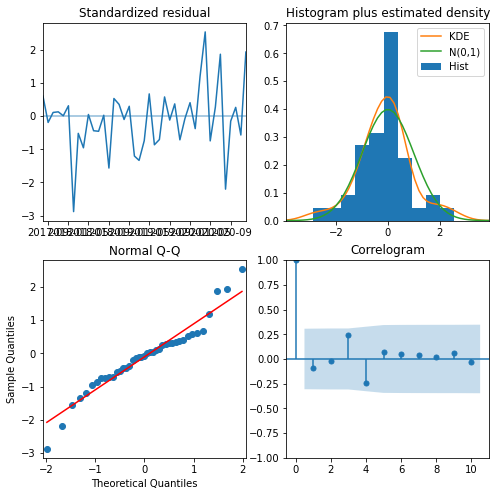

In [57]:
step_wise = pm.auto_arima(train_quantity, start_p=1, start_q=1,
                         max_p=7, max_q=7,m=12,seasonal_test_args={"max_lag": 1}, seasonal=True,
                         d=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,random_state=42)
print(step_wise.summary())
step_wise.plot_diagnostics(figsize=(8,8))
plt.show()

In [58]:
model= SARIMAX(train_quantity, order=(2,1,1),seasonal_order=(1,0,0,12),enforce_invertibility=False, 
               enforce_stationarity=False)
model_fit = model.fit()
print(model_fit.summary())

quantity["Forecast"] = model_fit.predict(start=pred_start,end=pred_end)


                                      SARIMAX Results                                      
Dep. Variable:                 Quantity Per Person   No. Observations:                   42
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                 -64.601
Date:                             Fri, 09 Sep 2022   AIC                            139.202
Time:                                     19:32:01   BIC                            145.681
Sample:                                 07-01-2017   HQIC                           141.129
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0204      0.205     -4.974      0.000      -1.422      -0.618
ar.L2         -0.7820      

<AxesSubplot:ylabel='Density'>

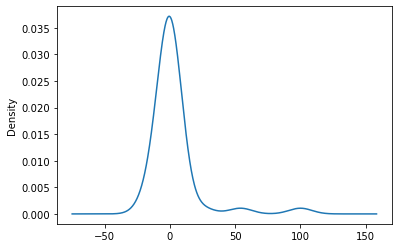

In [59]:
model_fit.resid.plot(kind='kde')

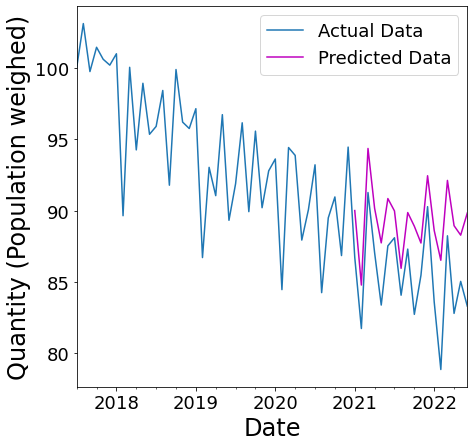

In [60]:

fig, ax = plt.subplots(figsize=(7,7))
ax = quantity["Quantity Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Quantity per Person (mg)'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Quantity (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
quantity["Forecast"].plot(ax=ax, style='m', label='Predicted Data')
legend = ax.legend(loc='upper right',prop={'size': 18})
plt.show()
fig.savefig('Quantity uni.jpg')

In [61]:
model_evaluation_metrics(quantity["Quantity Per Person"][42:], quantity["Forecast"][42:])

{'Mean Absolute Percentage Error': 0.043403569856187825,
 'Mean Absolute Error': 3.865432193182318,
 'Root Mean Square Error': 4.218985863176766,
 'Correlation Between Actual and Predicted/Forecasted Values': 0.8402697558639707,
 'Min-Max Error': 0.043403569856187985}

---
## Forecasting Quantity

In [62]:
future_dates = [items.index[-1]+ DateOffset(months=x) for x in range(0,31)]

In [63]:
future_dates_quantity = pd.DataFrame(index = future_dates[1:],columns=quantity.columns)


In [64]:
future_forecast_quantity = pd.concat([quantity,future_dates_quantity])
del future_forecast_quantity["Forecast"]

In [65]:
pred_start_future_quantity = future_forecast_quantity.index[59]
pred_end_future_quantity = future_forecast_quantity.index[-1]

In [66]:
model= SARIMAX(future_forecast_quantity, 
 order=(2,1,1),seasonal_order=(1,0,0,12),
 enforce_invertibility=False, enforce_stationarity=False)

future_model = model.fit()
print(future_model.summary())

future_forecast_quantity["Forecast"] = future_model.predict(start=pred_start_future_quantity,end=pred_end_future_quantity,
                                                         dynamic=True)

                                      SARIMAX Results                                      
Dep. Variable:                 Quantity Per Person   No. Observations:                   90
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                -104.210
Date:                             Fri, 09 Sep 2022   AIC                            218.420
Time:                                     19:32:01   BIC                            230.007
Sample:                                 07-01-2017   HQIC                           223.047
                                      - 12-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5937      0.182     -3.263      0.001      -0.950      -0.237
ar.L2         -0.4842      

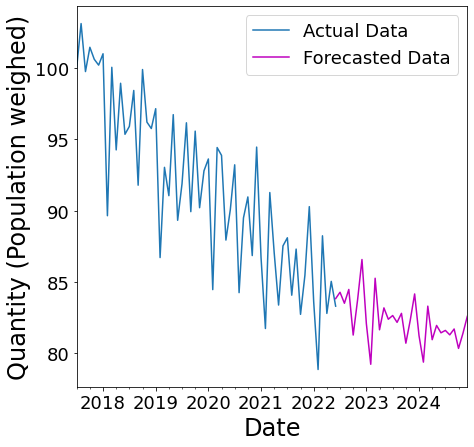

In [67]:
fig, ax = plt.subplots(figsize=(7,7))
ax = future_forecast_quantity["Quantity Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Quantity per Person'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Quantity (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
future_forecast_quantity["Forecast"].plot(ax=ax, style='m', label='Forecasted Data')
legend = ax.legend(loc='upper right',prop={'size': 18})
plt.show()
fig.savefig('Quantity forecast.jpg')

---
## Cost (Using IMD-Cost correlation as an exogenous variable)

In [68]:
corr_data = pd.read_excel('/Users/bharathsimha/Downloads/MSC Data Science/Project/Data/Correlation Month Forecast Data.xlsx')

In [69]:
corr_data

,IOD Feature,Anxiolytic Feature,Coefficient of Correlation,Level,Year,Month,Spearman Coefficient,Day
0,Index of Multiple Deprivation,Cost,0.065694,LSOA,2017,7,0.066,1
1,Income,Cost,-0.076337,LSOA,2017,7,-0.076,1
2,Employment,Cost,-0.158033,LSOA,2017,7,-0.158,1
3,"Education, Skills and Training",Cost,-0.145511,LSOA,2017,7,-0.146,1
4,Health Deprivation and Disability,Cost,-0.190418,LSOA,2017,7,-0.190,1
...,...,...,...,...,...,...,...,...
4495,"Education, Skills and Training",Item,-0.337959,LAD,2022,6,-0.338,1
4496,Health Deprivation and Disability,Item,-0.343536,LAD,2022,6,-0.344,1
4497,Crime,Item,0.093165,LAD,2022,6,0.093,1
4498,Barriers to Houses and Services,Item,0.230486,LAD,2022,6,0.230,1


In [70]:
corr_data = corr_data[(corr_data["IOD Feature"]=="Index of Multiple Deprivation")&(corr_data["Level"]=='LAD')]

In [71]:
del corr_data["Level"]

In [72]:
corr_data

,IOD Feature,Anxiolytic Feature,Coefficient of Correlation,Year,Month,Spearman Coefficient,Day
3060,Index of Multiple Deprivation,Cost,-0.379833,2017,7,-0.380,1
3068,Index of Multiple Deprivation,Cost,-0.374269,2017,8,-0.374,1
3076,Index of Multiple Deprivation,Cost,-0.376088,2017,9,-0.376,1
3084,Index of Multiple Deprivation,Cost,-0.346199,2017,10,-0.346,1
3092,Index of Multiple Deprivation,Cost,-0.379581,2017,11,-0.380,1
...,...,...,...,...,...,...,...
4460,Index of Multiple Deprivation,Item,-0.232492,2022,2,-0.232,1
4468,Index of Multiple Deprivation,Item,-0.236069,2022,3,-0.236,1
4476,Index of Multiple Deprivation,Item,-0.243950,2022,4,-0.244,1
4484,Index of Multiple Deprivation,Item,-0.229254,2022,5,-0.229,1


In [73]:
corr_data["Day"] = corr_data["Day"].astype(int)

In [74]:
corr_data["Date"] = corr_data.apply(lambda x: datetime.date(x['Year'], x['Month'], x['Day']), axis=1)

In [75]:
corr_data.drop(["Year",'Month','Day','IOD Feature','Coefficient of Correlation'],inplace=True,axis=1)

In [76]:
corr_data

,Anxiolytic Feature,Spearman Coefficient,Date
3060,Cost,-0.380,2017-07-01
3068,Cost,-0.374,2017-08-01
3076,Cost,-0.376,2017-09-01
3084,Cost,-0.346,2017-10-01
3092,Cost,-0.380,2017-11-01
...,...,...,...
4460,Item,-0.232,2022-02-01
4468,Item,-0.236,2022-03-01
4476,Item,-0.244,2022-04-01
4484,Item,-0.229,2022-05-01


In [77]:
corr_cost = corr_data[(corr_data["Anxiolytic Feature"]=="Cost")]

In [78]:
corr_cost.drop(["Anxiolytic Feature"],inplace=True,axis=1)

In [79]:
cost=cost.reset_index()

In [80]:
corr_cost['Date'] =  pd.to_datetime(corr_cost['Date'],yearfirst=True)

In [81]:
corr_cost = pd.merge(corr_cost,cost,on="Date",how="left")

In [82]:
del corr_cost["Forecast"]

In [83]:
corr_cost = corr_cost.set_index("Date")

In [84]:
corr_cost.tail()

,Spearman Coefficient,Cost Per Person
Date,,
2022-02-01,-0.299,9.750041
2022-03-01,-0.289,11.251876
2022-04-01,-0.301,10.503535
2022-05-01,-0.296,10.919038
2022-06-01,-0.283,10.951438


In [85]:
train_cost_corr = corr_cost["Cost Per Person"][:30]
test_cost_corr = corr_cost["Cost Per Person"][30:]
train_exog_cost = corr_cost["Spearman Coefficient"][:30]
test_exog_cost = corr_cost["Spearman Coefficient"][30:]
pred_start = test_cost_corr.index[0]
pred_end = test_cost_corr.index[-1]


In [86]:
pred_start

Timestamp('2020-01-01 00:00:00')

In [87]:
pred_end

Timestamp('2022-06-01 00:00:00')

<AxesSubplot:xlabel='Date'>

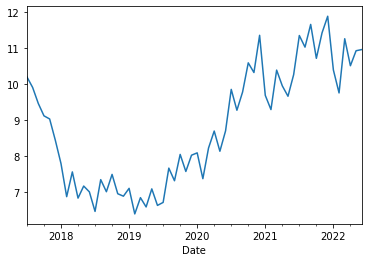

In [88]:
corr_cost["Cost Per Person"].plot()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=75.202, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=47.781, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=50.272, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=47.095, Time=0.15 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=60.039, Time=0.11 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=41.717, Time=0.15 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(2,

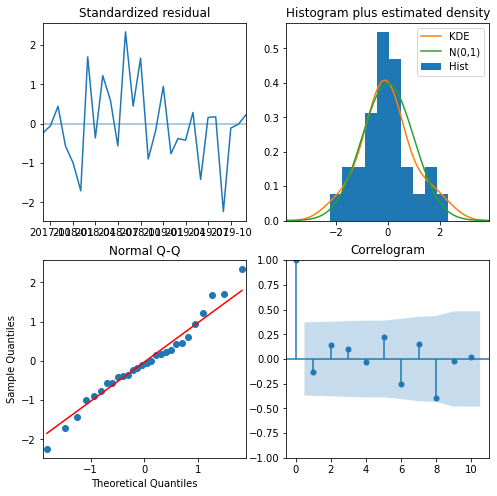

In [89]:
step_wise = pm.auto_arima(train_cost_corr, exogenous=train_exog_cost, start_p=1, start_q=1,
                         max_p=7, max_q=7,m=12,seasonal_test_args={"max_lag": 1}, seasonal=True,
                         d=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,random_state=42)

print(step_wise.summary())
step_wise.plot_diagnostics(figsize=(8,8))
plt.show()

In [90]:
model= SARIMAX(train_cost_corr, order=(0,1,0),seasonal_order=(2,0,1,12),enforce_invertibility=False,exog= train_exog_cost, 
               enforce_stationarity=False)

model_fit = model.fit()
print(model_fit.summary())

corr_cost["Forecast"] = model_fit.predict(start=pred_start,end=pred_end,exog= test_exog_cost)


                                      SARIMAX Results                                       
Dep. Variable:                      Cost Per Person   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood                   3.203
Date:                              Fri, 09 Sep 2022   AIC                              3.595
Time:                                      19:32:10   BIC                              1.642
Sample:                                  07-01-2017   HQIC                            -1.646
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Spearman Coefficient     2.4115      5.299      0.455      0.649      -7.974  

<AxesSubplot:ylabel='Density'>

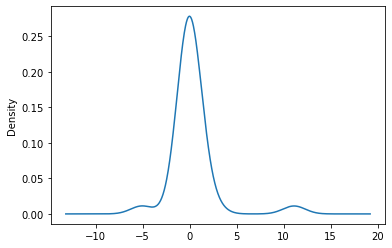

In [91]:
model_fit.resid.plot(kind='kde')

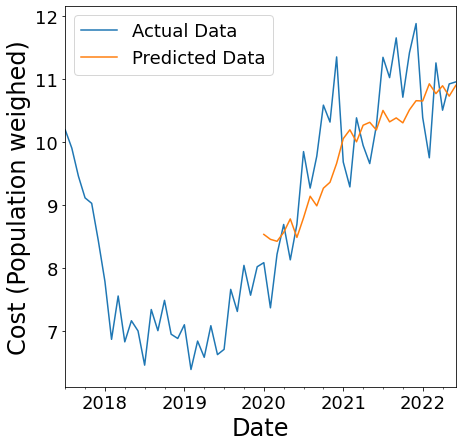

In [92]:
fig, ax = plt.subplots(figsize=(7,7))
ax = corr_cost["Cost Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Cost per Person (Pound Sterling)'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Cost (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
corr_cost["Forecast"].plot(ax=ax, style='-', label='Predicted Data')
legend = ax.legend(loc='upper left',prop={'size': 18})
plt.show()
fig.savefig('Cost bi.jpg')

In [93]:
model_evaluation_metrics(corr_cost["Cost Per Person"][30:], corr_cost["Forecast"][30:])

{'Mean Absolute Percentage Error': 0.06555966292288264,
 'Mean Absolute Error': 0.6407369959903039,
 'Root Mean Square Error': 0.7720675471051465,
 'Correlation Between Actual and Predicted/Forecasted Values': 0.7637420848824101,
 'Min-Max Error': 0.06152624992932609}

---
## Items (Using IMD-Item correlation as an exogenous variable)

In [94]:
corr_item = corr_data[(corr_data["Anxiolytic Feature"]=="Item")]

In [95]:
corr_item.drop(["Anxiolytic Feature"],inplace=True,axis=1)


In [96]:
items=items.reset_index()

In [97]:
corr_item['Date'] =  pd.to_datetime(corr_item['Date'],yearfirst=True)
corr_item = pd.merge(corr_item,items,on="Date",how="left")

In [98]:
del corr_item["Forecast"]

In [99]:
corr_item = corr_item.set_index("Date")

In [100]:
corr_item.tail()


,Spearman Coefficient,Items Per Person
Date,,
2022-02-01,-0.232,2.587277
2022-03-01,-0.236,2.909954
2022-04-01,-0.244,2.704125
2022-05-01,-0.229,2.801486
2022-06-01,-0.235,2.719740


In [101]:
train_item_corr = corr_item["Items Per Person"][:42]
test_item_corr = corr_item["Items Per Person"][42:]
train_exog_item = corr_item["Spearman Coefficient"][:42]
test_exog_item = corr_item["Spearman Coefficient"][42:]
pred_start = test_item_corr.index[0]
pred_end = test_item_corr.index[-1]

<AxesSubplot:xlabel='Date'>

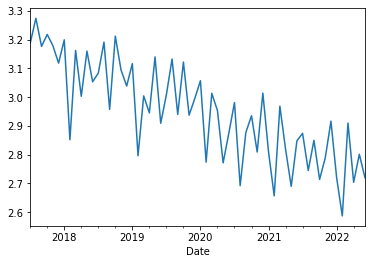

In [102]:
corr_item["Items Per Person"].plot()


In [ ]:
step_wise = pm.auto_arima(train_item_corr,exogenous=train_exog_item, start_p=1, start_q=1,
                         max_p=7, max_q=7,m=12,seasonal_test_args={"max_lag": 1}, seasonal=True,
                         d=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,random_state=42)
print(step_wise.summary())
step_wise.plot_diagnostics(figsize=(8,8))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-65.903, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-23.916, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-51.394, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-25.891, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-66.176, Time=0.37 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-49.409, Time=0.17 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-63.711, Time=0.31 sec

In [ ]:
model= SARIMAX(train_item_corr, order=(2,1,0),seasonal_order=(1,0,0,12),enforce_invertibility=False,exog= train_exog_item, 
               enforce_stationarity=False)

model_fit = model.fit()
print(model_fit.summary())

In [ ]:
corr_item["Forecast"] = model_fit.predict(start=pred_start,end=pred_end,exog= test_exog_item)

In [ ]:
model_fit.resid.plot(kind='kde')

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ax = corr_item["Items Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Items per Person'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Items (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
corr_item["Forecast"].plot(ax=ax, style='r', label='Predicted Data')
legend = ax.legend(loc='upper right',prop={'size': 18})
plt.show()
fig.savefig('Items bi.jpg')

In [ ]:
model_evaluation_metrics(corr_item["Items Per Person"][42:], corr_item["Forecast"][42:])

---
## Quantity (Using IMD-Quantity correlation as an exogenous variable)

In [ ]:
corr_quantity = corr_data[(corr_data["Anxiolytic Feature"]=="Quantity")]

In [ ]:
corr_quantity.drop(["Anxiolytic Feature"],inplace=True,axis=1)

In [ ]:
quantity=quantity.reset_index()

In [ ]:
corr_quantity['Date'] =  pd.to_datetime(corr_quantity['Date'],yearfirst=True)

In [ ]:
corr_quantity = pd.merge(corr_quantity,quantity,on="Date",how="left")

In [ ]:
del corr_quantity["Forecast"]

In [ ]:
corr_quantity = corr_quantity.set_index("Date")

In [ ]:
corr_quantity.tail()


In [ ]:
train_quantity_corr = corr_quantity["Quantity Per Person"][:42]
test_quantity_corr = corr_quantity["Quantity Per Person"][42:]
train_exog_quantity = corr_quantity["Spearman Coefficient"][:42]
test_exog_quantity = corr_quantity["Spearman Coefficient"][42:]
pred_start = test_quantity_corr.index[0]
pred_end = test_quantity_corr.index[-1]

In [ ]:
corr_quantity["Quantity Per Person"].plot()

In [ ]:
step_wise = pm.auto_arima(train_quantity_corr, start_p=1, start_q=1,
                         max_p=7, max_q=7,m=12,seasonal_test_args={"max_lag": 1}, seasonal=True,
                         d=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True,random_state=42)

print(step_wise.summary())
step_wise.plot_diagnostics(figsize=(8,8))
plt.show()

In [ ]:
model= SARIMAX(train_quantity_corr,order=(2,1,1),seasonal_order=(1,0,0,12),enforce_invertibility=False,exog= train_exog_quantity, 
               enforce_stationarity=False)

model_fit = model.fit()
print(model_fit.summary())

corr_quantity["Forecast"] = model_fit.predict(start=pred_start,end=pred_end,exog= test_exog_quantity)



In [ ]:
model_fit.resid.plot(kind='kde')

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ax = corr_quantity["Quantity Per Person"].plot(label='Actual Data')
ax.set(
    xlabel='Date',
    ylabel='Quantity per Person (mg)'
)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Quantity (Population weighed)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
corr_quantity["Forecast"].plot(ax=ax, style='m', label='Predicted Data')
legend = ax.legend(loc='upper right',prop={'size': 18})
plt.show()
fig.savefig('Quantity bi.jpg')

In [ ]:
model_evaluation_metrics(corr_quantity["Quantity Per Person"][42:], corr_quantity["Forecast"][42:])

# Thank You
---
